Lab 04



Task-1: Short-time processing of speech

a) Load and visualize the waveform of the first 20 second of speech sample.

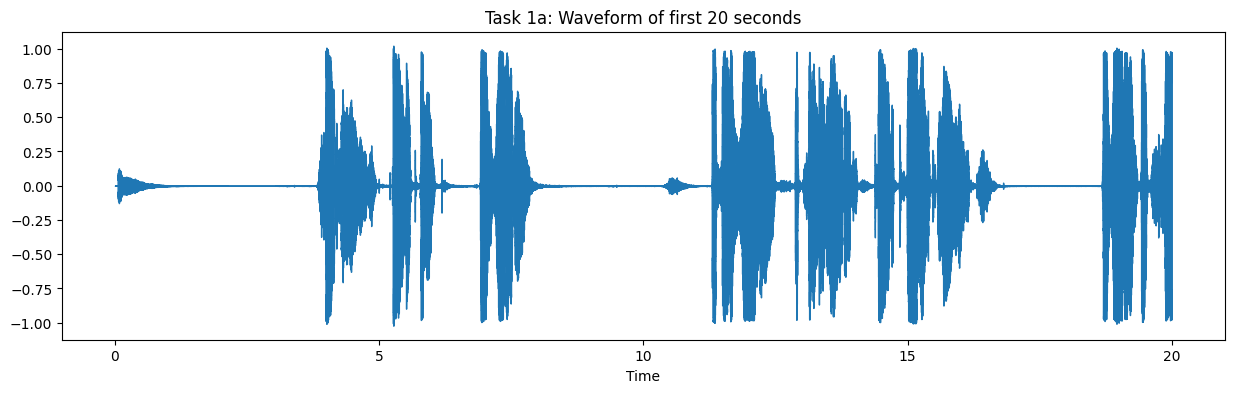

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Load speech sample (16 kHz as required)

audio_path = "Audio.wav"


y, sr = librosa.load(audio_path, sr=16000, duration=20.0)

# Visualize
plt.figure(figsize=(15, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Task 1a: Waveform of first 20 seconds")
plt.show()

b) Compute the total number of frames for a given frame length of 25ms and frame
shift of 10ms.

In [4]:
# Parameters
frame_size_ms = 25
frame_shift_ms = 10

# Convert to samples
L = int((frame_size_ms / 1000) * sr) # 400 samples
S = int((frame_shift_ms / 1000) * sr) # 160
total_samples = len(y)
num_frames = int(np.floor((total_samples - L) / S)) + 1

print(f"Total Samples: {total_samples}")
print(f"Frame Length (L): {L}")
print(f"Frame Shift (S): {S}")
print(f"Total Number of Frames (Task 1b): {num_frames}")

Total Samples: 320000
Frame Length (L): 400
Frame Shift (S): 160
Total Number of Frames (Task 1b): 1998


c) Segment the speech signal into overlapping frames using the calculated
parameters.  

In [5]:
# Create the frames array
frames = np.array([y[i*S : i*S + L] for i in range(num_frames)])
print(f"Shape of segmented frames: {frames.shape}")
print(frames)

Shape of segmented frames: (1998, 400)
[[ 8.6319911e-13 -1.5649093e-12 -5.9853789e-12 ... -2.7345890e-12
   4.3594932e-12 -1.0777698e-12]
 [ 1.7026835e-12  5.8467740e-12  3.0694947e-12 ...  3.2293374e-05
   2.0268562e-05  3.6600060e-05]
 [-2.3796603e-12  1.3112098e-12 -2.5371036e-12 ...  1.0537832e-04
   5.8406375e-05 -6.2843996e-05]
 ...
 [-4.4101036e-01 -5.6593186e-01 -6.0425651e-01 ...  9.7294700e-01
   9.3819749e-01  8.4662008e-01]
 [-1.9914751e-01 -2.5028821e-02  7.8905813e-02 ...  7.5990312e-02
  -9.7485296e-03 -1.4237179e-01]
 [ 9.6620941e-01  9.2752844e-01  9.3367088e-01 ... -4.7675738e-01
  -3.0548698e-01 -3.3545643e-01]]


d) Using Hamming window, extract the following time-domain features frame-wise:
• Short-Time Energy (STE)
• Short-Time Magnitude (STM)
• Zero-Crossing Rate (ZCR)
• Autocorrelation
• AMDF
• AMSDF

In [6]:
def get_time_domain_features(frames, window_type='hamming'):
    # Select window [cite: 12, 19]
    win = np.hamming(L) if window_type == 'hamming' else np.ones(L)

    ste, stm, zcr = [], [], []
    acf_list, amdf_list, amsdf_list = [], [], []

    for frame in frames:
        w_frame = frame * win # Apply window [cite: 12]

        # STE, STM, ZCR [cite: 13, 14, 15]
        ste.append(np.sum(w_frame**2))
        stm.append(np.sum(np.abs(w_frame)))
        zcr.append(np.sum(np.abs(np.diff(np.sign(w_frame)))) / (2 * L))

        # Periodicity features [cite: 16, 17, 18]
        # Autocorrelation (Positive lags)
        corr = np.correlate(w_frame, w_frame, mode='full')
        acf_list.append(corr[len(corr)//2:])

        # AMDF and AMSDF (Calculated for lags 0 to L/2)
        lags = np.arange(L // 2)
        amdf = [np.sum(np.abs(w_frame[lag:] - w_frame[:L-lag])) for lag in lags]
        amsdf = [np.sum((w_frame[lag:] - w_frame[:L-lag])**2) for lag in lags]

        amdf_list.append(np.array(amdf))
        amsdf_list.append(np.array(amsdf))

    return np.array(ste), np.array(stm), np.array(zcr), acf_list, amdf_list, amsdf_list

# Extract with Hamming [cite: 12]
ste_h, stm_h, zcr_h, acf_h, amdf_h, amsdf_h = get_time_domain_features(frames, 'hamming')

e) Repeat (b) using Rectangular window function.

In [7]:
# Extract with Rectangular (Repeat Task 1d logic) [cite: 19]
ste_r, stm_r, zcr_r, acf_r, amdf_r, amsdf_r = get_time_domain_features(frames, 'rect')

f) Plot the frame-wise variation of all six features for both window functions.  

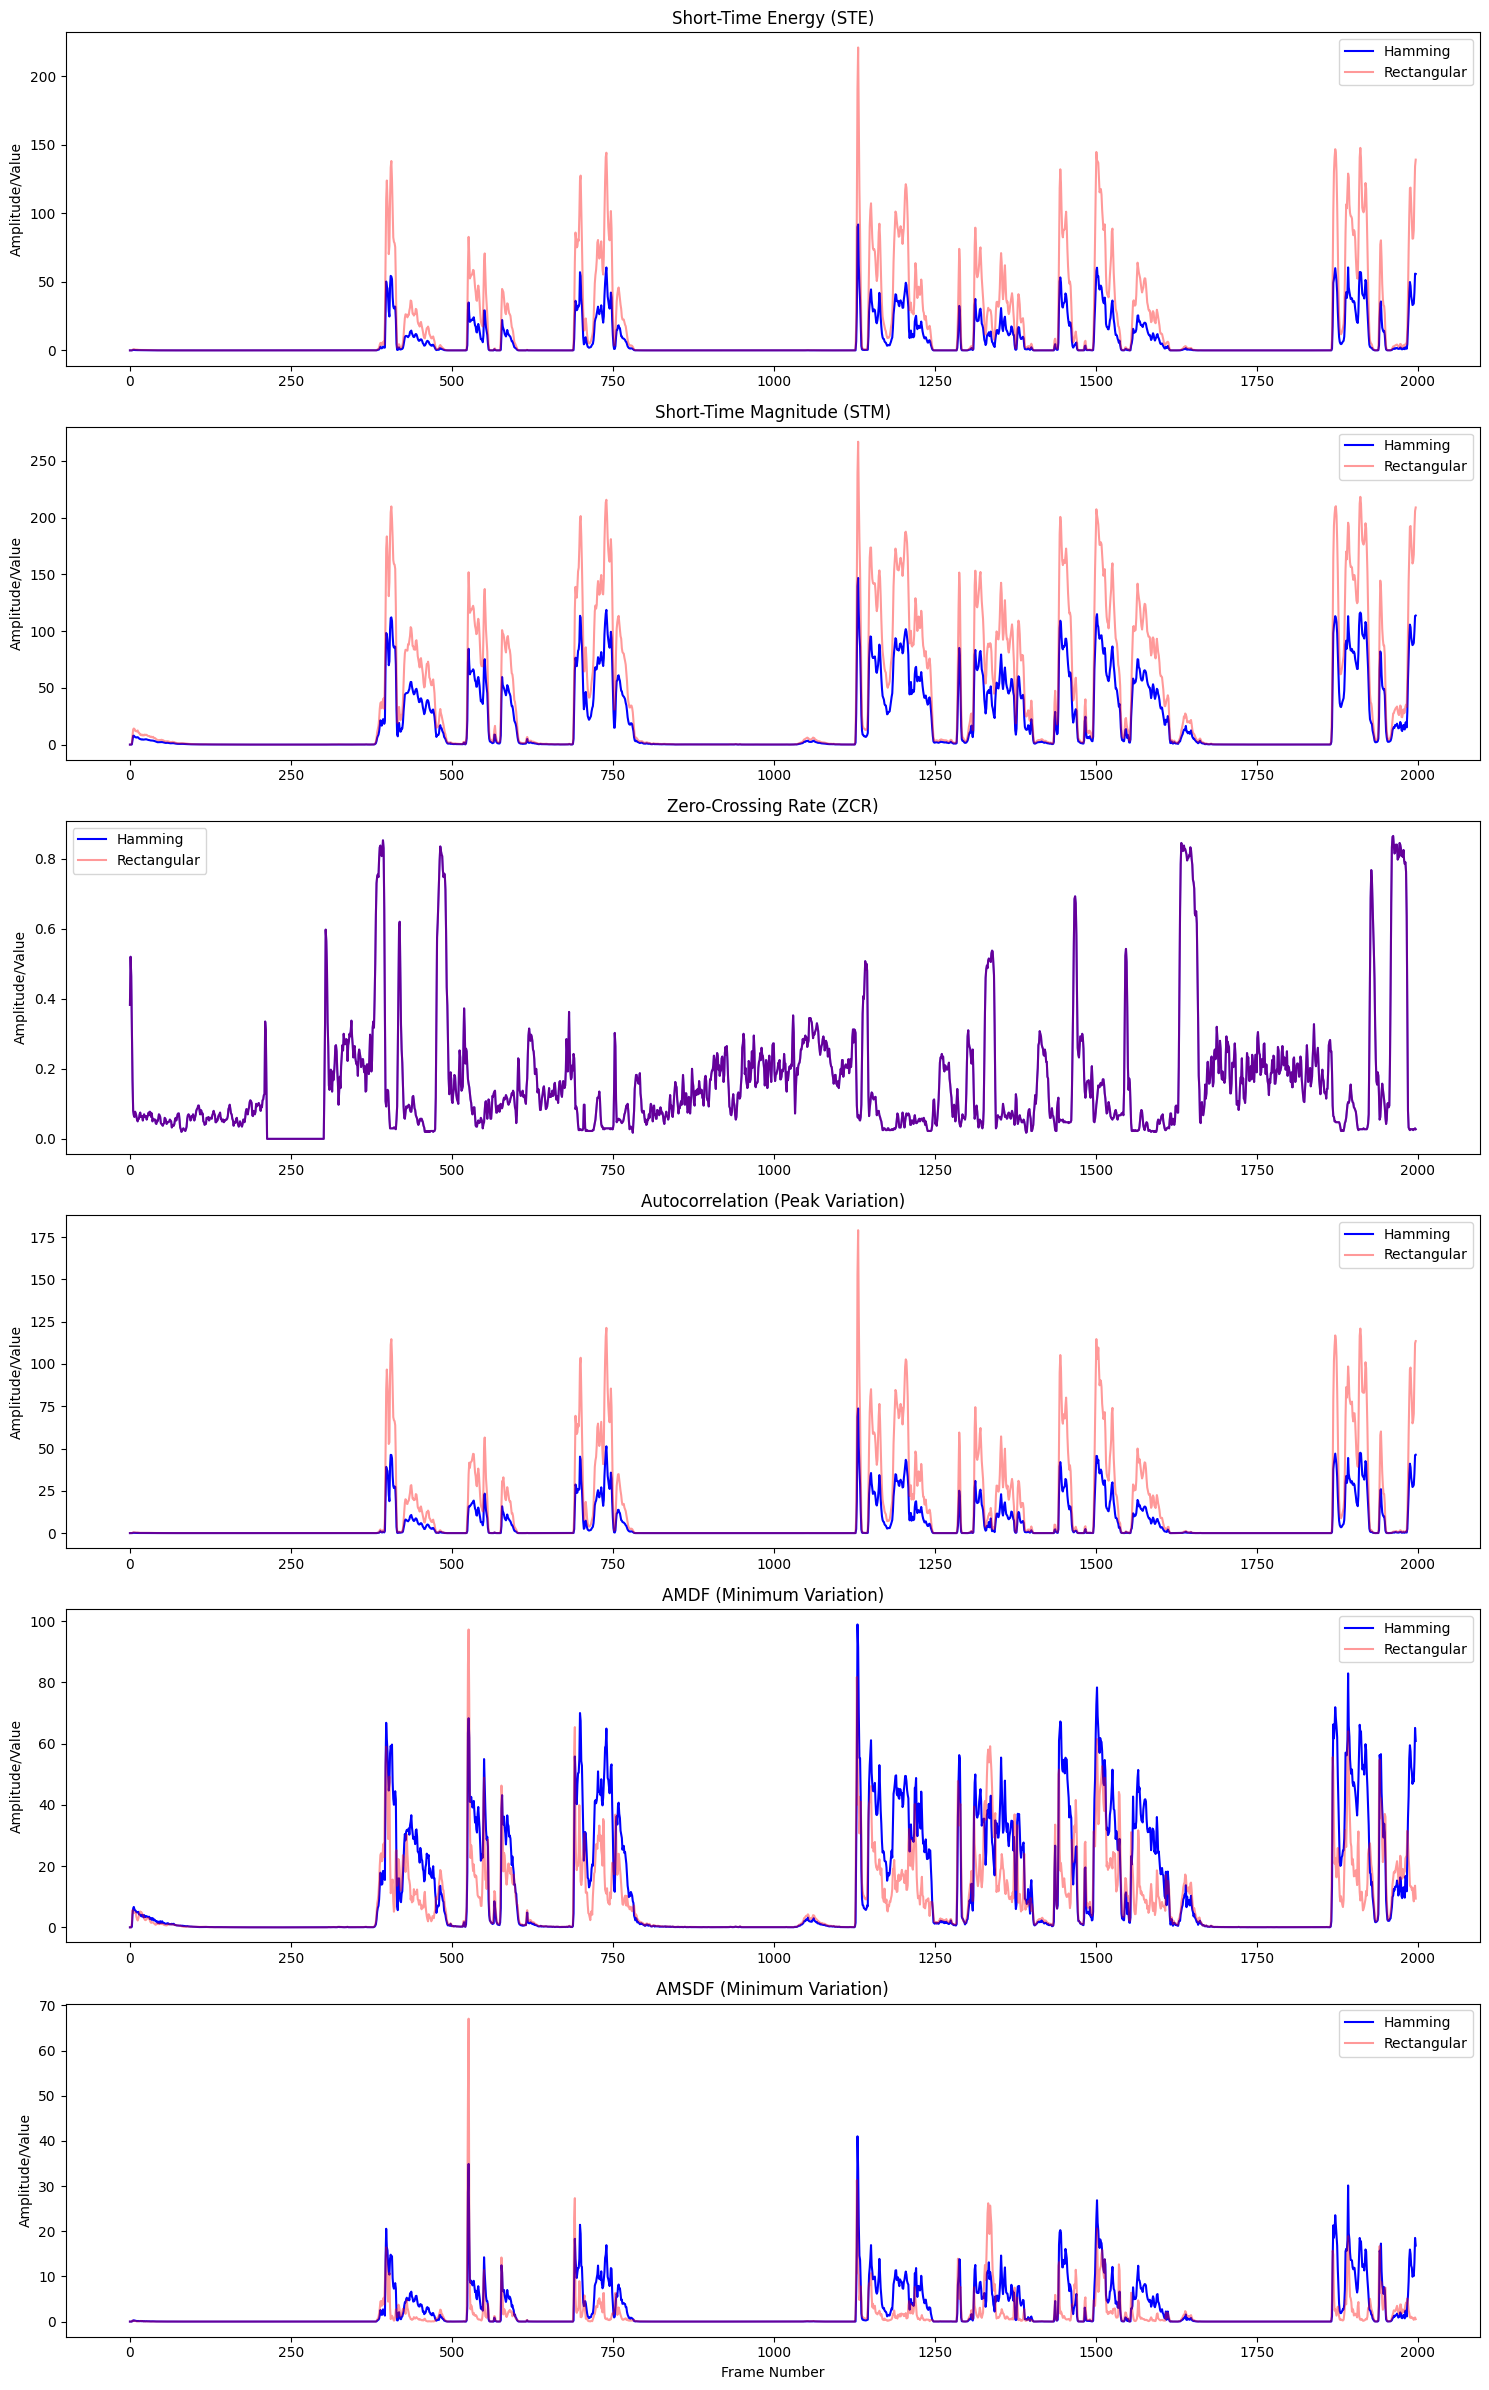

In [8]:
# Extracting representative values for the periodicity features (Task 1d & 1e)
def get_rep_values(acf, amdf, amsdf):
    # We skip the first 15 samples to avoid the trivial zero-lag peak/minimum
    acf_p = [np.max(f[15:]) if len(f) > 15 else 0 for f in acf]
    amdf_m = [np.min(f[15:]) if len(f) > 15 else 0 for f in amdf]
    amsdf_m = [np.min(f[15:]) if len(f) > 15 else 0 for f in amsdf]
    return acf_p, amdf_m, amsdf_m

# Representative values for Hamming
acf_p_h, amdf_m_h, amsdf_m_h = get_rep_values(acf_h, amdf_h, amsdf_h)
# Representative values for Rectangular
acf_p_r, amdf_m_r, amsdf_m_r = get_rep_values(acf_r, amdf_r, amsdf_r)

# Plotting all 6 features to compare Hamming vs Rectangular
fig, ax = plt.subplots(6, 1, figsize=(15, 24))

features_h = [ste_h, stm_h, zcr_h, acf_p_h, amdf_m_h, amsdf_m_h]
features_r = [ste_r, stm_r, zcr_r, acf_p_r, amdf_m_r, amsdf_m_r]
titles = [
    "Short-Time Energy (STE)",
    "Short-Time Magnitude (STM)",
    "Zero-Crossing Rate (ZCR)",
    "Autocorrelation (Peak Variation)",
    "AMDF (Minimum Variation)",
    "AMSDF (Minimum Variation)"
]

for i in range(6):
    # Hamming window: solid blue line
    ax[i].plot(features_h[i], label='Hamming', color='blue')
    # Rectangular window: semi-transparent red line
    ax[i].plot(features_r[i], label='Rectangular', color='red', alpha=0.4)
    ax[i].set_title(titles[i])
    ax[i].legend()
    ax[i].set_ylabel("Amplitude/Value")

ax[5].set_xlabel("Frame Number")
plt.tight_layout()
plt.show()

g) Analysis of Time-Domain Features: Voiced vs. Unvoiced Speech
Based on the plotted features, we can observe distinct behavioral differences between voiced speech (e.g., vowels, produced by vocal cord vibration) and unvoiced speech (e.g., fricatives like /s/ or /sh/, produced by turbulent airflow).

Feature Observations:

Short-Time Energy (STE): Voiced segments exhibit significantly higher energy compared to unvoiced segments due to the high-amplitude, periodic nature of vocal cord vibrations. Unvoiced segments have very low energy.

Short-Time Magnitude (STM): Similar to STE, STM is high for voiced regions and low for unvoiced regions. It provides a smoother contour than STE as it is less sensitive to extreme amplitude outliers.

Zero-Crossing Rate (ZCR): Voiced segments have a consistently low ZCR because the signal is dominated by the low-frequency fundamental pitch. Unvoiced segments display a distinctly high ZCR due to their noise-like, high-frequency characteristics.

Autocorrelation: In voiced segments, the autocorrelation function shows clear, distinct peaks at regular intervals corresponding to the fundamental pitch period. In unvoiced segments, the function lacks periodicity and drops off rapidly to zero.

AMDF (Average Magnitude Difference Function): For voiced speech, the AMDF exhibits deep, periodic valleys (local minima) that correspond to the pitch period. For unvoiced speech, there are no distinct periodic valleys, and the plot appears random.

AMSDF (Average Magnitude Squared Difference Function): This behaves similarly to the AMDF. Voiced segments show pronounced, sharp valleys at the pitch period, while unvoiced segments show a lack of periodic structure.

Summary of Findings:
Energy-based features (STE, STM) effectively distinguish between the high-amplitude voiced and low-amplitude unvoiced segments. Frequency-indicator features (ZCR) clearly separate low-frequency voiced speech from high-frequency unvoiced speech. Finally, periodicity features (Autocorrelation, AMDF, AMSDF) are highly reliable for identifying the presence or absence of a fundamental pitch, effectively separating periodic voiced sounds from random unvoiced noise.

h) Effect of Window Choice on Feature Smoothness and Discrimination
The choice between a Hamming window and a Rectangular window significantly impacts the quality of the extracted features.

Feature Smoothness:

Rectangular Window: This window abruptly cuts off the signal at the frame boundaries, introducing sharp discontinuities at the edges of the frames. This artificial high-frequency noise leads to jagged, less smooth feature contours across adjacent frames.

Hamming Window: This window gently tapers the signal amplitude to zero at the edges. By smoothing out the frame boundaries, it removes abrupt edge transitions, resulting in much smoother and more continuous feature variations from one frame to the next.

Discrimination Capability:

The Hamming window offers superior discrimination capability. Because the Rectangular window introduces artificial edge discontinuities, it can artificially inflate the Zero-Crossing Rate (ZCR) and distort the Short-Time Energy (STE) at frame boundaries. This makes it harder to accurately distinguish between voiced and unvoiced segments, especially during transition periods.

By minimizing spectral leakage and edge artifacts, the Hamming window ensures that the extracted features genuinely represent the underlying speech signal, making the classification between voiced and unvoiced frames much more reliable.

2.

### Task-2: Periodicity Analysis: Using Autocorrelation, AMDF, and AMSDF
a) Identify frames that exhibit periodic behaviour.

b) Explain how periodicity is reflected in these functions (peaks in autocorrelation, minima in AMDF/AMSDF).

c) Distinguish between periodic (voiced) and aperiodic (unvoiced) frames.

Automatically selected Voiced Frame Index: 1131
Automatically selected Unvoiced Frame Index: 1962


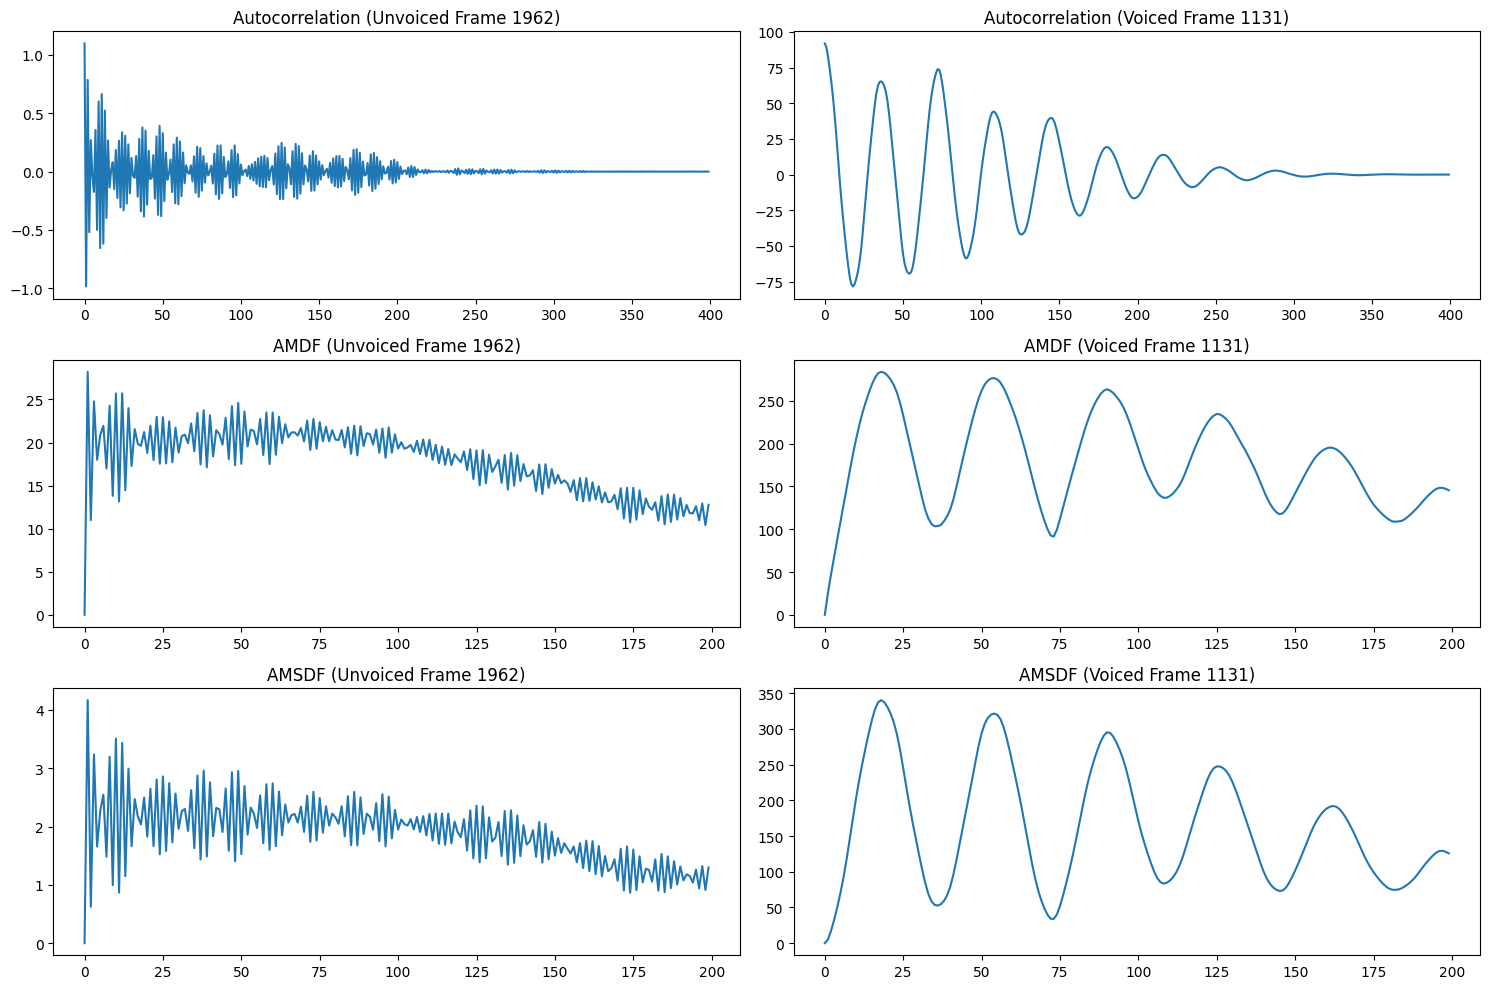

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Automatically find a voiced frame using Short-Time Energy (STE)
# The frame with the maximum energy is virtually guaranteed to be a strong voiced vowel.
voiced_idx = np.argmax(ste_h)

# Automatically find an unvoiced frame using Zero-Crossing Rate (ZCR)
# The frame with the maximum ZCR corresponds to high-frequency noise-like unvoiced speech.
unvoiced_idx = np.argmax(zcr_h)

print(f"Automatically selected Voiced Frame Index: {voiced_idx}")
print(f"Automatically selected Unvoiced Frame Index: {unvoiced_idx}")

fig, ax = plt.subplots(3, 2, figsize=(15, 10))

# Plot Autocorrelation
ax[0, 0].plot(acf_h[unvoiced_idx])
ax[0, 0].set_title(f"Autocorrelation (Unvoiced Frame {unvoiced_idx})")
ax[0, 1].plot(acf_h[voiced_idx])
ax[0, 1].set_title(f"Autocorrelation (Voiced Frame {voiced_idx})")

# Plot AMDF
ax[1, 0].plot(amdf_h[unvoiced_idx])
ax[1, 0].set_title(f"AMDF (Unvoiced Frame {unvoiced_idx})")
ax[1, 1].plot(amdf_h[voiced_idx])
ax[1, 1].set_title(f"AMDF (Voiced Frame {voiced_idx})")

# Plot AMSDF
ax[2, 0].plot(amsdf_h[unvoiced_idx])
ax[2, 0].set_title(f"AMSDF (Unvoiced Frame {unvoiced_idx})")
ax[2, 1].plot(amsdf_h[voiced_idx])
ax[2, 1].set_title(f"AMSDF (Voiced Frame {voiced_idx})")

plt.tight_layout()
plt.show()

Total Frames: 1998
Periodic (Voiced) Frames Detected: 556
Aperiodic (Unvoiced) Frames Detected: 1442


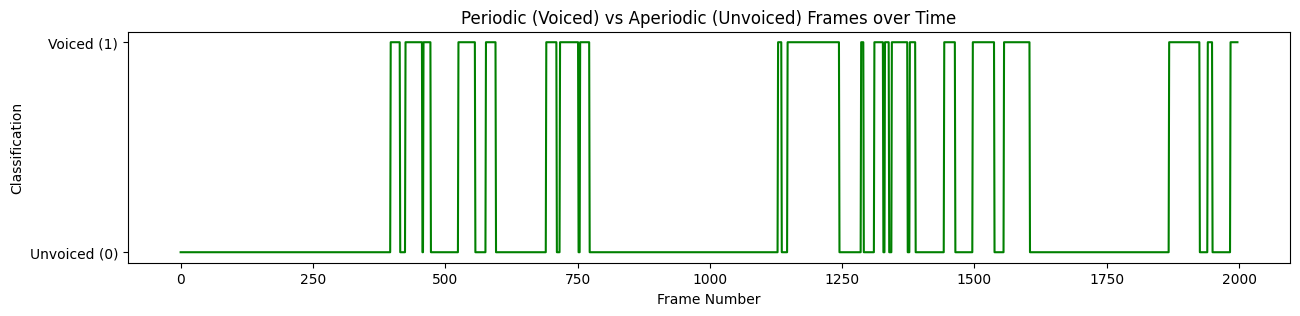

In [12]:
# c) Distinguish between periodic (voiced) and aperiodic (unvoiced) frames
# We can use a threshold combination of Short-Time Energy (STE) and the Autocorrelation peak
# because voiced frames naturally have higher energy and a stronger ACF peak.

# Set thresholds based on the mean of the features
energy_threshold = np.mean(ste_h) * 0.5
acf_threshold = np.mean(acf_p_h) * 0.5

is_periodic = []

for i in range(num_frames):
    # A frame is identified as periodic (voiced) if its energy and max ACF peak are above the thresholds
    if ste_h[i] > energy_threshold and acf_p_h[i] > acf_threshold:
        is_periodic.append(True)
    else:
        is_periodic.append(False)

periodic_frames_count = sum(is_periodic)
aperiodic_frames_count = num_frames - periodic_frames_count

print(f"Total Frames: {num_frames}")
print(f"Periodic (Voiced) Frames Detected: {periodic_frames_count}")
print(f"Aperiodic (Unvoiced) Frames Detected: {aperiodic_frames_count}")

# Plotting the Voiced/Unvoiced decision over time
plt.figure(figsize=(15, 3))
plt.plot(is_periodic, color='green')
plt.title("Periodic (Voiced) vs Aperiodic (Unvoiced) Frames over Time")
plt.xlabel("Frame Number")
plt.ylabel("Classification")
plt.yticks([0, 1], ['Unvoiced (0)', 'Voiced (1)'])
plt.show()

3. Task-3: Pitch Estimation: For frames identified as periodic,

```
a) Determine the pitch period from the lag corresponding to the first prominent
autocorrelation peak (excluding zero lag) or the first minimum of AMDF and AMSDF.
b) Compute the pitch frequency and infer about the result.
```




In [13]:
# Select a periodic (voiced) frame identified in Task 2
frame = frames[voiced_idx]
win = np.hamming(L)
w_frame = frame * win

# 3a) Determine the pitch period from the lag (excluding zero lag) [cite: 29]
# Pitch search range for typical human voice (approx 80Hz to 400Hz)
lag_min = int(sr / 400)
lag_max = int(sr / 80)

# --- 1. Pitch from Autocorrelation ---
ac = np.correlate(w_frame, w_frame, mode='full')
ac = ac[len(ac)//2:]
ac = ac / np.max(ac) # Normalize

# Search in pitch range for first prominent peak
search_region_ac = ac[lag_min:lag_max]
pitch_lag_ac = np.argmax(search_region_ac) + lag_min
pitch_freq_ac = sr / pitch_lag_ac # F0 = Fs / Lag

print("--- Autocorrelation Pitch Results ---")
print("Pitch Period (samples):", pitch_lag_ac)
print("Pitch Frequency (Hz):", pitch_freq_ac)

# --- 2. Pitch from AMDF ---
amdf_vals = []
for k in range(lag_min, lag_max):
    # Calculate Average Magnitude Difference [cite: 24, 26]
    diff = w_frame[k:] - w_frame[:-k]
    amdf_vals.append(np.mean(np.abs(diff)))

amdf_vals = np.array(amdf_vals)
pitch_lag_amdf = np.argmin(amdf_vals) + lag_min
pitch_freq_amdf = sr / pitch_lag_amdf # F0 = Fs / Lag [cite: 30]

print("\n--- AMDF Pitch Results ---")
print("Pitch Period (samples):", pitch_lag_amdf)
print("Pitch Frequency (Hz):", pitch_freq_amdf)

# --- 3. Pitch from AMSDF ---
amsdf_vals = []
for k in range(lag_min, lag_max):
    # Calculate Average Magnitude Squared Difference [cite: 24, 26]
    diff = w_frame[k:] - w_frame[:-k]
    amsdf_vals.append(np.mean(diff**2))

amsdf_vals = np.array(amsdf_vals)
pitch_lag_amsdf = np.argmin(amsdf_vals) + lag_min
pitch_freq_amsdf = sr / pitch_lag_amsdf # F0 = Fs / Lag [cite: 30]

print("\n--- AMSDF Pitch Results ---")
print("Pitch Period (samples):", pitch_lag_amsdf)
print("Pitch Frequency (Hz):", pitch_freq_amsdf)

--- Autocorrelation Pitch Results ---
Pitch Period (samples): 73
Pitch Frequency (Hz): 219.17808219178082

--- AMDF Pitch Results ---
Pitch Period (samples): 73
Pitch Frequency (Hz): 219.17808219178082

--- AMSDF Pitch Results ---
Pitch Period (samples): 73
Pitch Frequency (Hz): 219.17808219178082




```
4. Discussion
 a) Comparison of Voiced and Unvoiced Speech: Voiced speech is characterized by high energy and low Zero-Crossing Rate (ZCR) because of the low-frequency,
  high-power vibrations of the vocal cords. In contrast, unvoiced speech is aperiodic (noise-like), leading to low energy and high ZCR.
 b) Periodicity-based Features in Pitch Detection: Features like Autocorrelation identify the point where a signal
 matches its delayed version (peaks), while AMDF/AMSDF identify where the difference is minimized (minima).
 These specific lags represent the time period ($T_0$) of one vibration cycle.
 c) Reliability for Pitch Detection:
Autocorrelation: Highly reliable and robust to noise, but computationally expensive due to many multiplications. * AMDF/AMSDF: Computationally faster
(using subtractions/additions), making them suitable for real-time systems, though they
can be sensitive to amplitude changes.
* ZCR/Energy: These are better for distinguishing if a frame is voiced or unvoiced rather than detecting the specific pitch frequency itself.
```

